For more informatin and to download the dataset click [here](https://www.kaggle.com/datasets/evqueniyero/consumer-segmentation-data)

# Importing libraries

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA

from yellowbrick.cluster import SilhouetteVisualizer
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline
from random import sample
from numpy.random import uniform

# to display all the columns of the dataframe in the notebook
pd.pandas.set_option('display.max_columns', None)

# Loading data

In [2]:
data = pd.read_csv('segmentation_data.csv')
data.head()

,ID,Sex,Marital_status,Age,Education,Income,Occupation,Settlement_size
0,100000001,0,0,67,2,124670,1,2
1,100000002,1,1,22,1,150773,1,2
2,100000003,0,0,49,1,89210,0,0
3,100000004,0,0,45,1,171565,1,1
4,100000005,0,0,53,1,149031,1,1


In [3]:
data.Settlement_size.unique()

array([2, 0, 1])

In [4]:
# # remove target variable "Settlement_size" and "ID" column.

X = data.drop(['Settlement_size', 'ID'], axis=1)
X.head(3)

,Sex,Marital_status,Age,Education,Income,Occupation
0,0,0,67,2,124670,1
1,1,1,22,1,150773,1
2,0,0,49,1,89210,0


# Features Engeering

## Scaling

Scaling  continuous variables, 'Age' and 'Income'

In [5]:
scaler = StandardScaler()

In [6]:
# fitting
scaler.fit(X[['Age', 'Income']])

StandardScaler()

In [7]:

X[['Age', 'Income']] = scaler.transform(X[['Age', 'Income']])
X.head()

,Sex,Marital_status,Age,Education,Income,Occupation
0,0,0,2.653614,2,0.097524,1
1,1,1,-1.187132,1,0.782654,1
2,0,0,1.117316,1,-0.833202,0
3,0,0,0.775916,1,1.328386,1
4,0,0,1.458716,1,0.736932,1


# Evaluating data clusterability

## Hopkins test

The Hopkins test is is a way of measuring the clusterability of a dataset. The range of Hopkins score from 0-1, with scores colser to 1 indicates high clusterability.

In [8]:
# The following function is used to calcualte the Hopkins score can be accessed using this link. 
# : https://github.com/prathmachowksey/Hopkins-Statistic-Clustering-Tendency/blob/master/Hopkins-Statistic-Clustering-Tendency.ipynb
# Curtsy to the auther of the the auther.

# function to compute hopkins's statistic for the dataframe X
def hopkins_statistic(X):
    
    X=X.values  #convert dataframe to a numpy array
    sample_size = int(X.shape[0]*0.05) #0.05 (5%) based on paper by Lawson and Jures
    
    
    #a uniform random sample in the original data space
    X_uniform_random_sample = uniform(X.min(axis=0), X.max(axis=0) ,(sample_size , X.shape[1]))
    
    
    
    #a random sample of size sample_size from the original data X
    random_indices=sample(range(0, X.shape[0], 1), sample_size)
    X_sample = X[random_indices]
   
    
    #initialise unsupervised learner for implementing neighbor searches
    neigh = NearestNeighbors(n_neighbors=2)
    nbrs=neigh.fit(X)
    
    #u_distances = nearest neighbour distances from uniform random sample
    u_distances , u_indices = nbrs.kneighbors(X_uniform_random_sample , n_neighbors=2)
    u_distances = u_distances[: , 0] #distance to the first (nearest) neighbour
    
    #w_distances = nearest neighbour distances from a sample of points from original data X
    w_distances , w_indices = nbrs.kneighbors(X_sample , n_neighbors=2)
    #distance to the second nearest neighbour (as the first neighbour will be the point itself, with distance = 0)
    w_distances = w_distances[: , 1]
    
 
    
    u_sum = np.sum(u_distances)
    w_sum = np.sum(w_distances)
    
    #compute and return hopkins' statistic
    H = u_sum/ (u_sum + w_sum)
    return H
    

In [9]:
# call the function on the scaled dataset
H=hopkins_statistic(X)

# calculate the averge of 20 runs.
l = [] #list to hold values for each call
for i in range(20):
    H=hopkins_statistic(X)
    l.append(H)
#print average value:
round((np.mean(l)),2)

0.92

The value of 0.92 indicate that data has high cluster tendency.

# Inspecting the possible number of cluster 
## Elbo method / KMeans Clustering

In [10]:
# A function to check optimum number of clusters
def optimise_k_means (data, max_k):
    means = []
    inertias = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k,n_init= 'auto')
        kmeans.fit (X)
        
        means.append(k)
        inertias.append (kmeans.inertia_)
    #Generate the elbow plot
    fig =plt.subplots(figsize=(10,5))
    plt.plot(means, inertias,'o-')
    plt.xlabel( 'Number of Clusters') 
    plt.ylabel('Inertia') 
    plt.grid(True) 
    plt.show()

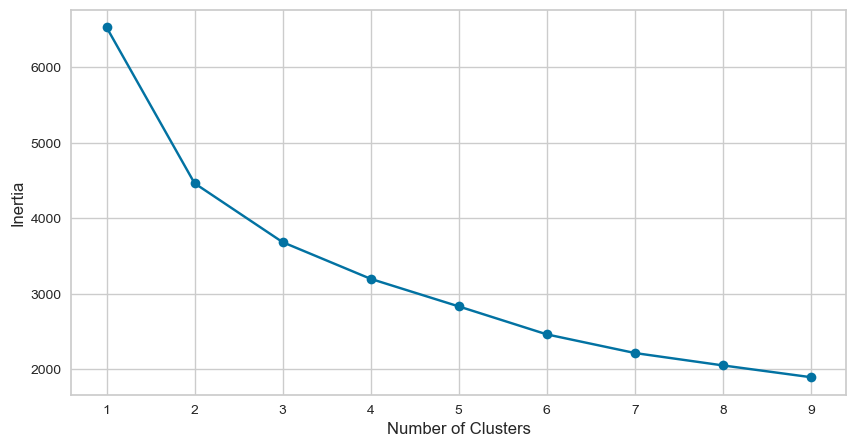

In [11]:
# Using complete dataset
optimise_k_means(X, 10)

Seems 2 and 3 clusters are good choices. Will proceed with n_clusters=3 

## Applyting selected n_clusters=3

In [12]:
kmeans = KMeans(n_clusters=3, n_init= 'auto')
kmeans.fit (X)
        

KMeans(n_clusters=3, n_init='auto')

In [13]:
# add labels to dataset based on results from fitting kmean with n_clusters=3
X['kmean_3'] = kmeans.labels_

In [14]:
X.head()

,Sex,Marital_status,Age,Education,Income,Occupation,kmean_3
0,0,0,2.653614,2,0.097524,1,2
1,1,1,-1.187132,1,0.782654,1,1
2,0,0,1.117316,1,-0.833202,0,2
3,0,0,0.775916,1,1.328386,1,0
4,0,0,1.458716,1,0.736932,1,2


## Plotting

<Axes: xlabel='Income', ylabel='Age'>

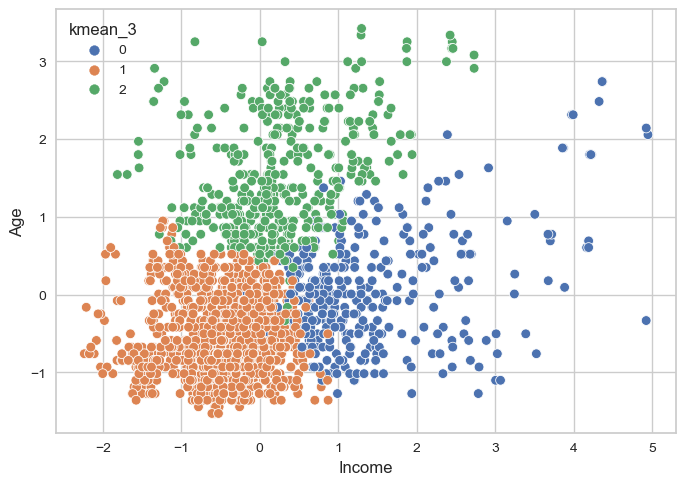

In [15]:
sns.scatterplot(data=X, x="Income", y="Age", hue="kmean_3", palette="deep")

##  Confirming the optimal number of cluster using Silhouette plots

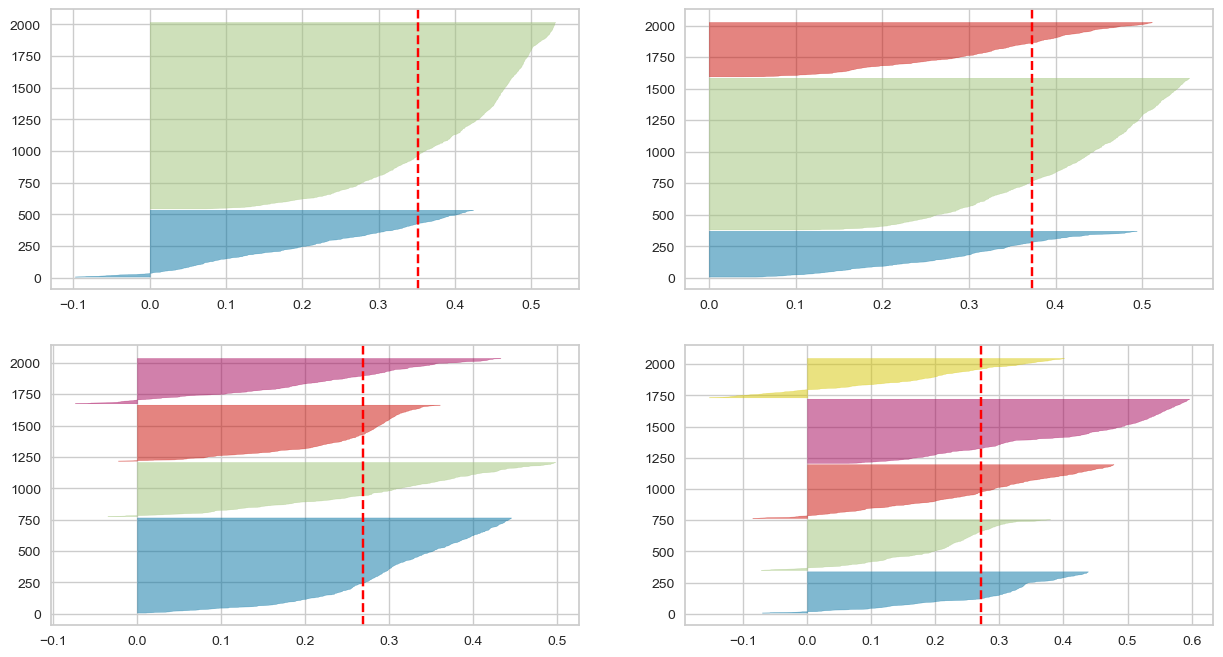

In [16]:

fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(X)

Visually it is clear that upper right figur, which represents model with n_clusters = 3, gives best performance but it show any neagtive values. All other graphs have some values below 0.

In [17]:
silhouette_score(X, km.labels_)

0.27156842315211466

# PCA/ Kmean

[lecture](https://365datascience.com/tutorials/python-tutorials/pca-k-means/)

## PCA analysis

In [18]:
x = X.drop('kmean_3', axis=1)

In [19]:
pca =PCA()

In [20]:
pca.fit(x)

PCA()

In [21]:
pca.explained_variance_ratio_

array([0.48604186, 0.2636171 , 0.14612345, 0.05171296, 0.03450096,
       0.01800366])

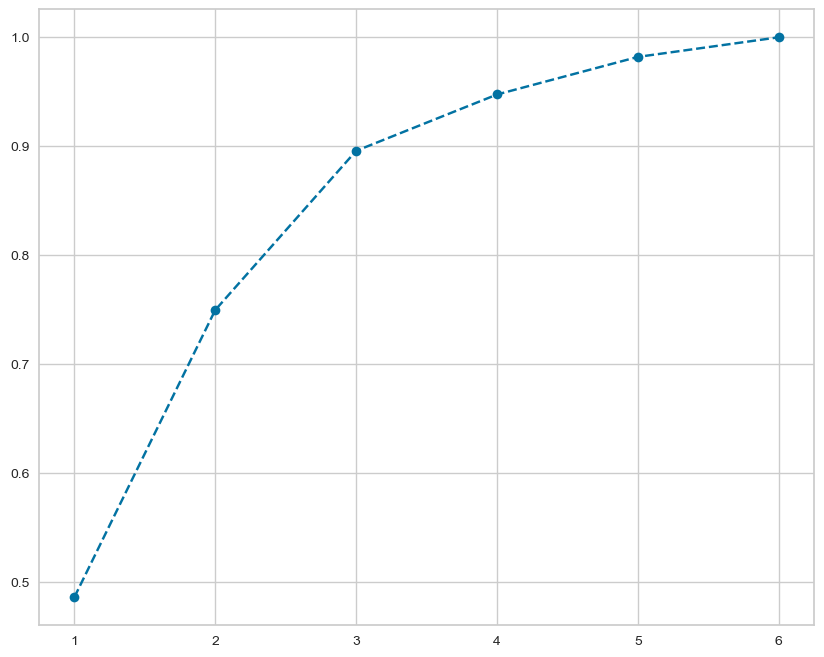

In [22]:
plt.figure(figsize = (10,8))
plt.plot(range(1,7), pca.explained_variance_ratio_.cumsum(), marker ='o',linestyle = '--')

From the graph above, 3 compontents will explaine about %90.

In [23]:
pca =PCA(n_components=3)
pca.fit(x)

PCA(n_components=3)

In [24]:
pca.transform(x)

array([[ 2.11027042,  1.84871499, -0.63098658],
       [-0.25924888, -1.22934744,  0.9409057 ],
       [-0.02836441,  1.45239353, -0.94717766],
       ...,
       [-1.30732419,  0.17194615, -1.11694961],
       [-1.36271885,  0.05186106,  0.70285901],
       [-1.9399759 ,  0.10227759, -1.06949674]])

In [25]:
pca_score = pca.transform(x)

## Elbo method / KMeans Clustering

In [26]:
# A function to check optimum number of clusters
def optimise_k_means (data, max_k):
    means = []
    inertias = []
    for k in range(1, max_k):
        kmeans = KMeans(n_clusters=k, n_init ='auto' )
        kmeans.fit (pca_score)
        
        means.append(k)
        inertias.append (kmeans.inertia_)
    #Generate the elbow plot
    fig =plt.subplots(figsize=(10,5))
    plt.plot(means, inertias,'o-')
    plt.xlabel( 'Number of Clusters') 
    plt.ylabel('Inertia') 
    plt.grid(True) 
    plt.show()

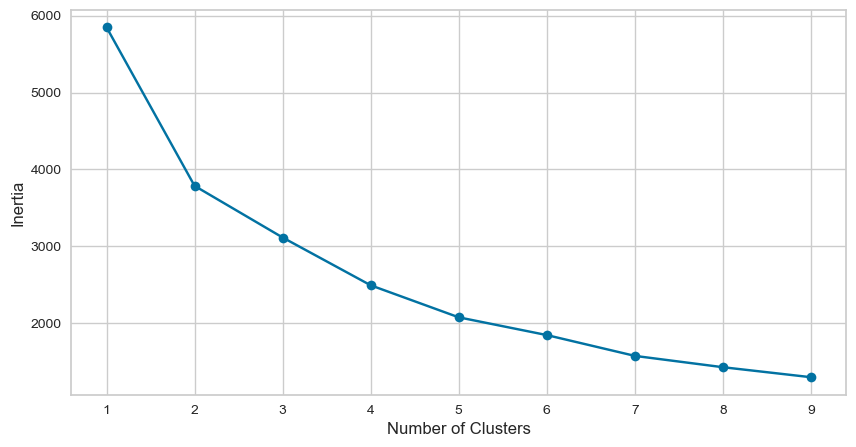

In [27]:
# Using complete dataset
optimise_k_means(pca_score, 10)

## Applyting selected n_clusters=3

In [28]:
kmeans = KMeans(n_clusters=3, random_state=0,n_init ='auto')
kmeans.fit (pca_score)
        

KMeans(n_clusters=3, n_init='auto', random_state=0)

In [29]:
df_pca_kmean =pd.concat([x.reset_index(drop =True),pd.DataFrame(pca_score)],axis =1)
df_pca_kmean.columns.values[-3:] = ['component_1', 'component_2', 'component_3']
df_pca_kmean

,Sex,Marital_status,Age,Education,Income,Occupation,component_1,component_2,component_3
0,0,0,2.653614,2,0.097524,1,2.110270,1.848715,-0.630987
1,1,1,-1.187132,1,0.782654,1,-0.259249,-1.229347,0.940906
2,0,0,1.117316,1,-0.833202,0,-0.028364,1.452394,-0.947178
3,0,0,0.775916,1,1.328386,1,1.482257,-0.360217,-0.590267
4,0,0,1.458716,1,0.736932,1,1.517051,0.397662,-0.788381
...,...,...,...,...,...,...,...,...,...
1995,1,0,0.946616,1,0.067471,0,0.365683,0.930813,-0.252454
1996,1,1,-0.760382,1,-0.084265,1,-0.566914,-0.484814,0.762160
1997,0,0,-0.418983,0,-0.906957,0,-1.307324,0.171946,-1.116950
1998,1,1,-1.016432,1,-0.603329,0,-1.362719,0.051861,0.702859


In [30]:
## Adding lables to the dataframe
df_pca_kmean['kmean_3'] = kmeans.labels_

In [31]:
df_pca_kmean

,Sex,Marital_status,Age,Education,Income,Occupation,component_1,component_2,component_3,kmean_3
0,0,0,2.653614,2,0.097524,1,2.110270,1.848715,-0.630987,2
1,1,1,-1.187132,1,0.782654,1,-0.259249,-1.229347,0.940906,0
2,0,0,1.117316,1,-0.833202,0,-0.028364,1.452394,-0.947178,1
3,0,0,0.775916,1,1.328386,1,1.482257,-0.360217,-0.590267,0
4,0,0,1.458716,1,0.736932,1,1.517051,0.397662,-0.788381,2
...,...,...,...,...,...,...,...,...,...,...
1995,1,0,0.946616,1,0.067471,0,0.365683,0.930813,-0.252454,2
1996,1,1,-0.760382,1,-0.084265,1,-0.566914,-0.484814,0.762160,1
1997,0,0,-0.418983,0,-0.906957,0,-1.307324,0.171946,-1.116950,1
1998,1,1,-1.016432,1,-0.603329,0,-1.362719,0.051861,0.702859,1


## Plotting

<Axes: xlabel='component_1', ylabel='component_2'>

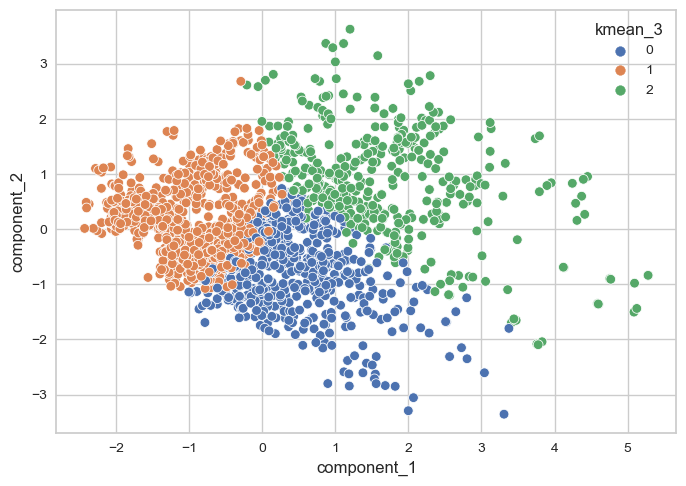

In [32]:
# Scatter plot of "component_1" and "component_2"
sns.scatterplot(data=df_pca_kmean, x="component_1", y="component_2", hue="kmean_3", palette="deep")

<Axes: xlabel='component_1', ylabel='component_3'>

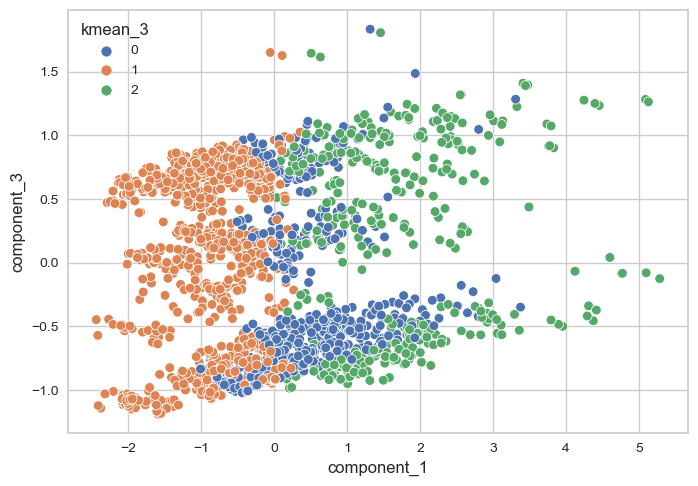

In [33]:
# Scatter plot of "component_1" and "component_3"
sns.scatterplot(data=df_pca_kmean, x="component_1", y="component_3", hue="kmean_3", palette="deep")

<Axes: xlabel='component_2', ylabel='component_3'>

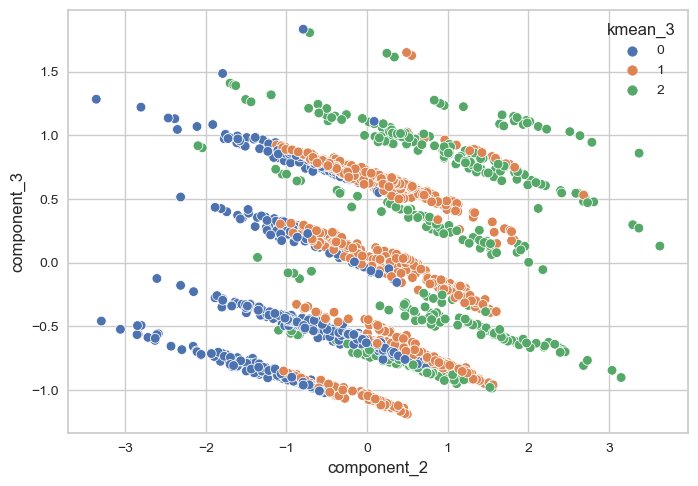

In [34]:
# Scatter plot of "component_2" and "component_3"

sns.scatterplot(data=df_pca_kmean, x="component_2", y="component_3", hue="kmean_3", palette="deep")

##  Confirming the optimal number of cluster using Silhouette plots

In [35]:
df_pca_kmean_sil = df_pca_kmean[['component_1','component_2','component_3']]
df_pca_kmean_sil

,component_1,component_2,component_3
0,2.110270,1.848715,-0.630987
1,-0.259249,-1.229347,0.940906
2,-0.028364,1.452394,-0.947178
3,1.482257,-0.360217,-0.590267
4,1.517051,0.397662,-0.788381
...,...,...,...
1995,0.365683,0.930813,-0.252454
1996,-0.566914,-0.484814,0.762160
1997,-1.307324,0.171946,-1.116950
1998,-1.362719,0.051861,0.702859


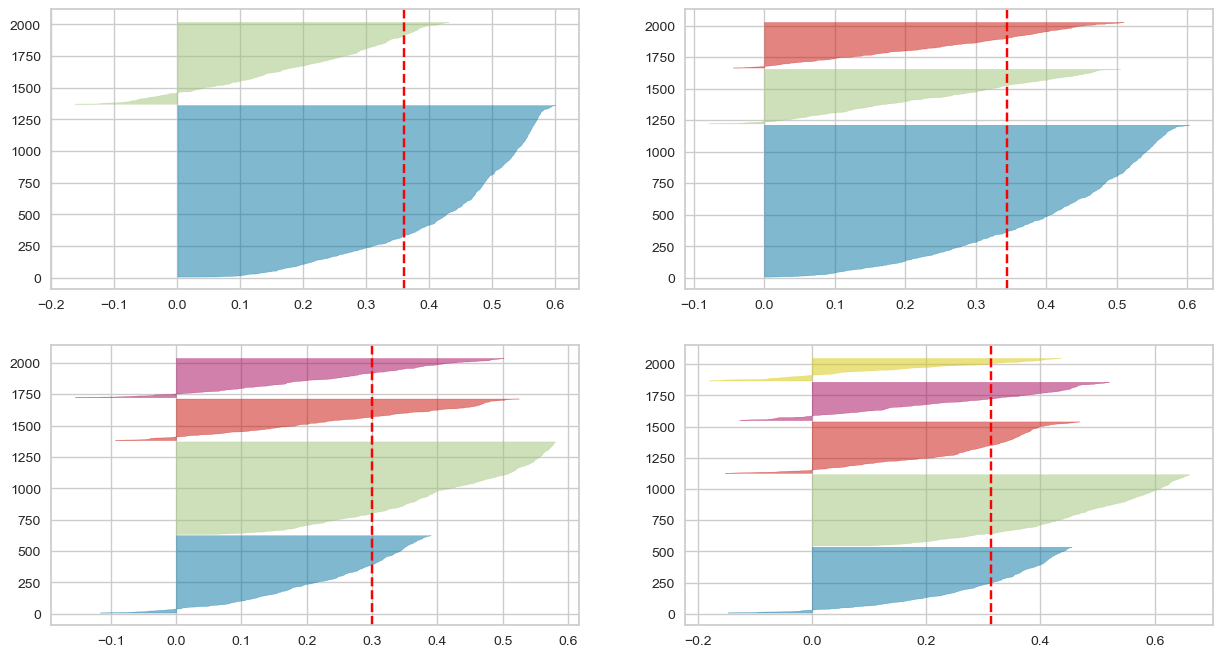

In [36]:
fig, ax = plt.subplots(2, 2, figsize=(15,8))
for i in [2, 3, 4, 5]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=42)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(df_pca_kmean_sil)

In [37]:
silhouette_score(df_pca_kmean_sil, km.labels_)

0.3132748091640199

Visually it is clear that all other graphs have some values below 0. It seems that applying PCA was not as good as using raw data. 